In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/KLTN/Dataset_CICIDS2017_sample_km.csv")

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0, D loss: 0.7205507755279541, G loss: 0.7860066890716553
Epoch 100, D loss: 0.8736599683761597, G loss: 0.48028483986854553
Epoch 200, D loss: 0.9086616039276123, G loss: 0.4356074929237366
Epoch 300, D loss: 0.9216756820678711, G loss: 0.41944360733032227
Epoch 400, D loss: 0.9290984869003296, G loss: 0.4104864299297333
Epoch 500, D loss: 0.9337265491485596, G loss: 0.4049455225467682
Epoch 600, D loss: 0.93687903881073, G loss: 0.4012024998664856
Epoch 700, D loss: 0.9391471147537231, G loss: 0.39847859740257263
Epoch 800, D loss: 0.9409379959106445, G loss: 0.396372526884079
Epoch 900, D loss: 0.9423836469650269, G loss: 0.3946932256221771
Epoch 1000, D loss: 0.943553626537323, G loss: 0.3933158218860626
Epoch 1100, D loss: 0.9445392489433289, G loss: 0.39217448234558105
Epoch 1200, D loss: 0.9453710317611694, G loss: 0.3912056088447571
Epoch 1300, D loss: 0.9460786581039429, G loss: 0.39037781953811646
Epoch 1400, D loss: 0.9466950297355652, G loss: 0.389657586812973
Epoch 1

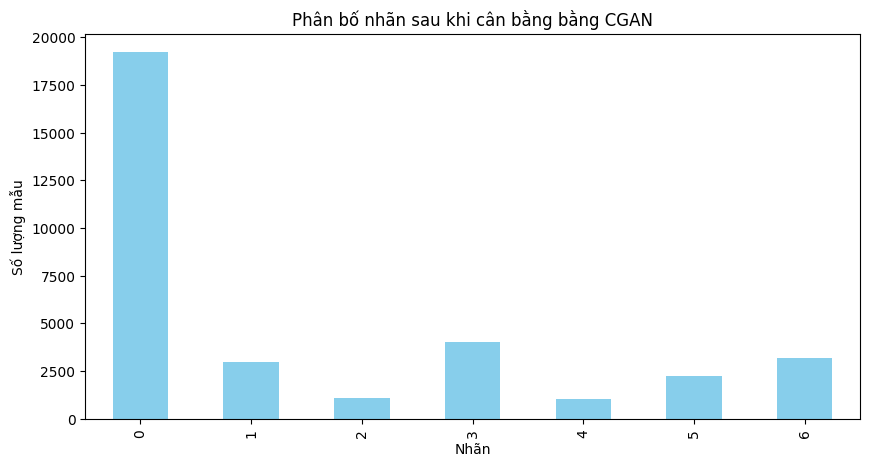

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt

scaler = MinMaxScaler()
df_scaled = df.copy()

# Chuẩn bị dữ liệu
X_train = df_scaled.drop(columns=['Label']).values
y_train = df_scaled['Label'].values.astype(int)

latent_dim = 100
num_classes = len(np.unique(y_train))
feature_dim = X_train.shape[1]

# Hàm tạo Generator
def build_generator():
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')

    label_embedding = Embedding(num_classes, latent_dim)(label)
    label_embedding = Flatten()(label_embedding)

    model_input = Concatenate()([noise, label_embedding])

    x = Dense(128, activation="relu")(model_input)
    x = Dense(256, activation="relu")(x)
    x = Dense(512, activation="relu")(x)
    x = Dense(feature_dim, activation="sigmoid")(x)

    model = Model([noise, label], x)
    return model

# Hàm tạo Discriminator
def build_discriminator():
    data_input = Input(shape=(feature_dim,))
    label = Input(shape=(1,), dtype='int32')

    label_embedding = Embedding(num_classes, feature_dim)(label)
    label_embedding = Flatten()(label_embedding)

    model_input = Concatenate()([data_input, label_embedding])

    x = Dense(512, activation="relu")(model_input)
    x = Dense(256, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)

    model = Model([data_input, label], x)
    return model

# Khởi tạo Generator và Discriminator
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])


discriminator.trainable = False

# Xây dựng CGAN
noise = Input(shape=(latent_dim,))
label = Input(shape=(1,))
generated_data = generator([noise, label])
validity = discriminator([generated_data, label])

cgan = Model([noise, label], validity)
cgan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Hàm huấn luyện CGAN
def train(epochs, batch_size=128):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data, real_labels = X_train[idx], y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_labels = np.random.randint(0, num_classes, batch_size, dtype=np.int32)  # Đảm bảo int32
        generated_data = generator.predict([noise, gen_labels], verbose=0)

        d_loss_real = discriminator.train_on_batch([real_data, real_labels], real)
        d_loss_fake = discriminator.train_on_batch([generated_data, gen_labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        sampled_labels = np.random.randint(0, num_classes, batch_size, dtype=np.int32)
        discriminator.trainable = False
        g_loss = cgan.train_on_batch([noise, sampled_labels], real)
        discriminator.trainable = True

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, D loss: {d_loss[0]}, G loss: {g_loss}")

# Huấn luyện CGAN
train(epochs=5000, batch_size=128)

# Sinh dữ liệu mới
num_samples_per_class = 1000
new_data = []
new_labels = []

for label in range(num_classes):
    noise = np.random.normal(0, 1, (num_samples_per_class, latent_dim))


    labels = np.full((num_samples_per_class,), label, dtype=np.int32)

    # 🔹 Kiểm tra kích thước trước khi predict
    print(f"Generating samples for label {label} - Noise shape: {noise.shape}, Labels shape: {labels.shape}")

    generated_samples = generator.predict([noise, labels], verbose=0)
    new_data.append(generated_samples)
    new_labels.append(labels)

new_data = np.vstack(new_data)
new_labels = np.hstack(new_labels)

X_balanced = np.vstack([X_train, new_data])
y_balanced = np.hstack([y_train, new_labels])

# Hiển thị số lượng nhãn sau khi cân bằng
label_counts = pd.Series(y_balanced).value_counts().sort_index()
print("Số lượng mẫu sau khi dùng CGAN:")
print(label_counts)

# Vẽ biểu đồ phân bố nhãn
plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar', color='skyblue')
plt.xlabel("Nhãn")
plt.ylabel("Số lượng mẫu")
plt.title("Phân bố nhãn sau khi cân bằng bằng CGAN")
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:49:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🏆 **Random Forest Results:**
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3845
           1       0.98      0.99      0.99       593
           2       1.00      0.99      0.99       219
           3       1.00      0.99      0.99       809
           4       1.00      0.98      0.99       207
           5       0.99      1.00      1.00       451
           6       1.00      0.98      0.99       636

    accuracy                           0.99      6760
   macro avg       0.99      0.99      0.99      6760
weighted avg       0.99      0.99      0.99      6760

Accuracy: 0.9931952662721893

🏆 **XGBoost Results:**
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3845
           1       1.00      1.00      1.00       593
           2       1.00      0.97      0.98       219
           3       1.00      1.00      1.00       809
           4       1.00      0.99      0.99       

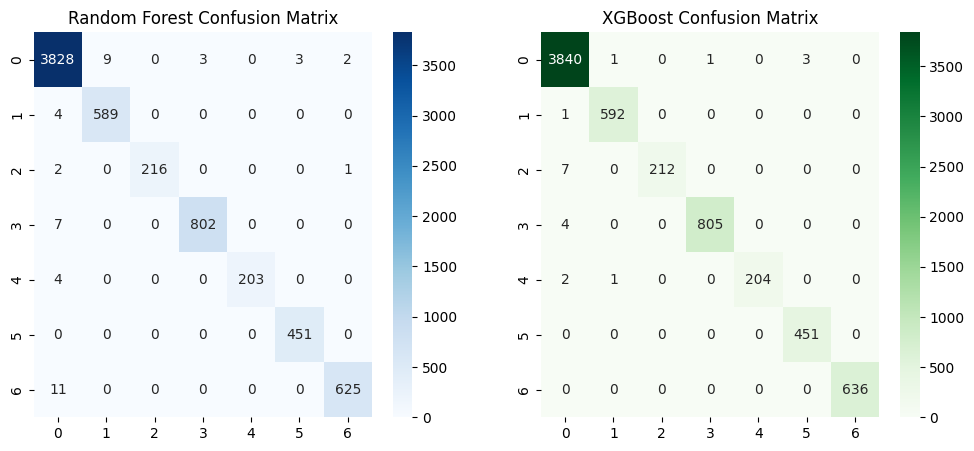

In [ ]:

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 🔹 Dữ liệu gốc + dữ liệu sinh từ CGAN
X_balanced = np.vstack([X_train, new_data])
y_balanced = np.hstack([y_train, new_labels])

# 🔹 Chuẩn hóa dữ liệu (nếu cần)
scaler = MinMaxScaler()
X_balanced = scaler.fit_transform(X_balanced)

# 🔹 Chia dữ liệu thành tập Train/Test (80/20)
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# 🔹 Huấn luyện Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_final, y_train_final)
rf_preds = rf_model.predict(X_test_final)

# 🔹 Huấn luyện XGBoost
xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_final, y_train_final)
xgb_preds = xgb_model.predict(X_test_final)

# 🔹 Đánh giá mô hình
print("🏆 **Random Forest Results:**")
print(classification_report(y_test_final, rf_preds))
print("Accuracy:", accuracy_score(y_test_final, rf_preds))

print("\n🏆 **XGBoost Results:**")
print(classification_report(y_test_final, xgb_preds))
print("Accuracy:", accuracy_score(y_test_final, xgb_preds))

# 🔹 Vẽ Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test_final, rf_preds), annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Random Forest Confusion Matrix")

sns.heatmap(confusion_matrix(y_test_final, xgb_preds), annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("XGBoost Confusion Matrix")

plt.show()


Số lượng mẫu sau khi áp dụng SMOTE:
0    14580
1    14580
5    14580
3    14580
6    14580
4    14580
2    14580
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:53:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🏆 **Random Forest Results:**
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3645
           1       0.97      0.99      0.98       393
           2       1.00      0.95      0.97        19
           3       0.99      1.00      0.99       609
           4       1.00      0.86      0.92         7
           5       0.99      1.00      0.99       251
           6       0.97      0.97      0.97       436

    accuracy                           0.99      5360
   macro avg       0.99      0.96      0.98      5360
weighted avg       0.99      0.99      0.99      5360

Accuracy: 0.9899253731343284

🏆 **XGBoost Results:**
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      0.99      0.99       393
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00       609
           4       1.00      0.86      0.92       

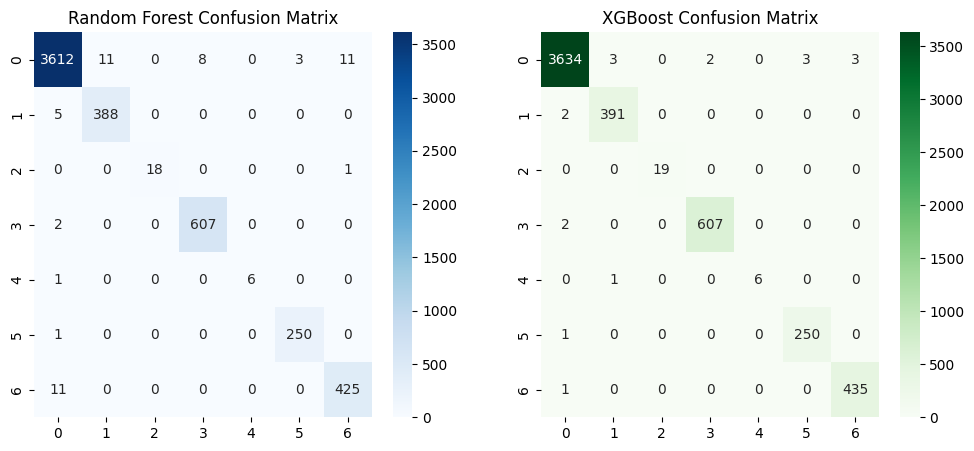

In [ ]:

from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 🔹 Chia dữ liệu ban đầu thành tập train/test
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# 🔹 Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_orig)
X_test_scaled = scaler.transform(X_test_orig)

# 🔹 Áp dụng SMOTE để tạo dữ liệu tổng hợp
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train_orig)

# 🔹 Hiển thị số lượng mẫu sau khi áp dụng SMOTE
print("Số lượng mẫu sau khi áp dụng SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# 🔹 Huấn luyện Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_smote, y_train_smote)
rf_preds = rf_model.predict(X_test_scaled)

# 🔹 Huấn luyện XGBoost
xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_smote, y_train_smote)
xgb_preds = xgb_model.predict(X_test_scaled)

# 🔹 Đánh giá mô hình
print("🏆 **Random Forest Results:**")
print(classification_report(y_test_orig, rf_preds))
print("Accuracy:", accuracy_score(y_test_orig, rf_preds))

print("\n🏆 **XGBoost Results:**")
print(classification_report(y_test_orig, xgb_preds))
print("Accuracy:", accuracy_score(y_test_orig, xgb_preds))

# 🔹 Vẽ Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test_orig, rf_preds), annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Random Forest Confusion Matrix")

sns.heatmap(confusion_matrix(y_test_orig, xgb_preds), annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("XGBoost Confusion Matrix")

plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# 📌 1. Chuẩn bị dữ liệu
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle dữ liệu
scaler = MinMaxScaler()
X = scaler.fit_transform(df.drop(columns=['Label']))
y = df['Label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📌 2. Xây dựng VAE
input_dim = X_train.shape[1]
latent_dim = 10

# Encoder
inputs = Input(shape=(input_dim,))
h = Dense(128, activation='relu')(inputs)
z_mean = Dense(latent_dim, name="z_mean")(h)
z_log_var = Dense(latent_dim, name="z_log_var")(h)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_h = Dense(128, activation='relu')
decoder_out = Dense(input_dim, activation='sigmoid')
h_decoded = decoder_h(z)
outputs = decoder_out(h_decoded)

# VAE Model (không tính loss)
vae = Model(inputs, outputs)

# Chỉ compile và huấn luyện mô hình VAE nếu cần
# vae.compile(optimizer=Adam(learning_rate=0.001))
# vae.fit(X_train, epochs=50, batch_size=32, validation_data=(X_test, None), verbose=1)

# 📌 3. Tạo dữ liệu tổng hợp từ VAE
encoder = Model(inputs, z_mean)
z_samples = np.random.normal(size=(len(X_train), latent_dim))  # Mẫu mới từ không gian tiềm ẩn
decoder_input = Input(shape=(latent_dim,))
h_decoded = decoder_h(decoder_input)
decoded_outputs = decoder_out(h_decoded)
decoder = Model(decoder_input, decoded_outputs)

generated_data = decoder.predict(z_samples)

# Gộp dữ liệu gốc + dữ liệu tổng hợp
X_extended = np.vstack((X_train, generated_data))
y_extended = np.hstack((y_train, y_train))  # Nhân đôi nhãn để giữ cân bằng

# 📌 4. Huấn luyện mô hình XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(X_extended, y_extended)
y_pred_xgb = xgb_model.predict(X_test)
print("Accuracy XGBoost:", accuracy_score(y_test, y_pred_xgb))

# 📌 5. Huấn luyện mô hình Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_extended, y_extended)
y_pred_rf = rf_model.predict(X_test)
print("Accuracy Random Forest:", accuracy_score(y_test, y_pred_rf))


670/670 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Accuracy XGBoost: 0.9966417910447761
Accuracy Random Forest: 0.9932835820895523


In [ ]:
from time import time
from sklearn.metrics import accuracy_score
import xgboost as xgb
import numpy as np

# Hàm huấn luyện và đánh giá
def train_and_evaluate(X_train, y_train, X_test, y_test, desc):
    start_time = time()
    model = xgb.XGBClassifier(objective="multi:softmax", eval_metric="mlogloss", use_label_encoder=False)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    end_time = time()
    print(f"{desc} - Độ chính xác: {acc:.4f}, Thời gian: {end_time - start_time:.2f}s")
    return acc

# Kiểm tra số lượng mẫu của VAE
print(f"Original X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"VAE-generated X_train_vae_78 shape: {X_train_vae_78.shape}")

# Mở rộng y_train nếu cần
y_train_vae_78 = np.tile(y_train, (X_train_vae_78.shape[0] // y_train.shape[0],))
y_train_vae_20 = np.tile(y_train, (X_train_vae_20.shape[0] // y_train.shape[0],))
y_train_vae_10 = np.tile(y_train, (X_train_vae_10.shape[0] // y_train.shape[0],))

# So sánh các phương pháp
print("\U0001F7E2 Kết quả huấn luyện trên 78 đặc trưng:")
train_and_evaluate(X_train_smote_78, y_train_smote_78, X_test, y_test, "SMOTE - 78 Features")
train_and_evaluate(X_train_cgan_78, y_train_cgan_78, X_test, y_test, "CGAN - 78 Features")
train_and_evaluate(X_train_vae_78, y_train_vae_78, X_test, y_test, "VAE - 78 Features")

print("\n\U0001F7E0 Kết quả huấn luyện trên 20 đặc trưng:")
train_and_evaluate(X_train_smote_20, y_train_smote_20, X_test_20, y_test, "SMOTE - 20 Features")
train_and_evaluate(X_train_cgan_20, y_train_cgan_20, X_test_20, y_test, "CGAN - 20 Features")
train_and_evaluate(X_train_vae_20, y_train_vae_20, X_test_20, y_test, "VAE - 20 Features")

print("\n\U0001F534 Kết quả huấn luyện trên 10 đặc trưng:")
train_and_evaluate(X_train_smote_10, y_train_smote_10, X_test_10, y_test, "SMOTE - 10 Features")
train_and_evaluate(X_train_cgan_10, y_train_cgan_10, X_test_10, y_test, "CGAN - 10 Features")
train_and_evaluate(X_train_vae_10, y_train_vae_10, X_test_10, y_test, "VAE - 10 Features")

Original X_train shape: (21440, 77), y_train shape: (21440,)
VAE-generated X_train_vae_78 shape: (42880, 77)
🟢 Kết quả huấn luyện trên 78 đặc trưng:


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:05:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


SMOTE - 78 Features - Độ chính xác: 0.9961, Thời gian: 25.60s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:05:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


CGAN - 78 Features - Độ chính xác: 0.9955, Thời gian: 19.11s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:06:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VAE - 78 Features - Độ chính xác: 0.9963, Thời gian: 16.86s

🟠 Kết quả huấn luyện trên 20 đặc trưng:


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:06:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


SMOTE - 20 Features - Độ chính xác: 0.9944, Thời gian: 9.75s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:06:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


CGAN - 20 Features - Độ chính xác: 0.9935, Thời gian: 8.16s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:06:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VAE - 20 Features - Độ chính xác: 0.9944, Thời gian: 4.72s

🔴 Kết quả huấn luyện trên 10 đặc trưng:


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:06:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


SMOTE - 10 Features - Độ chính xác: 0.8929, Thời gian: 8.58s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:06:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


CGAN - 10 Features - Độ chính xác: 0.9420, Thời gian: 3.55s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:07:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VAE - 10 Features - Độ chính xác: 0.9431, Thời gian: 3.32s


0.9430970149253731

In [2]:
!jupyter nbconvert --to html /content/drive/MyDrive/KLTN/IntrusionDetection.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/KLTN/IntrusionDetection.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 502893 bytes to /content/drive/MyDrive/KLTN/IntrusionDetection.html
